# Visualization
Given our failures with the integration with kafka, we decided to play safe and save the stream to file.

Obviously this is not realtime, but we decided to follow a contingency plan and at least deliver some visualizations

## Generate the file
spark streaming creates a folder for each RDD created in the discretized stream, and a file for each partition of the rdd. To concatenate them togheter and do some claenup issue this command in the `data` folder:

`
echo "precision,recall,tp,fn,fp,tn" > results.csv && cat results_final/*/part-* | sed  's/(//g; s/)//g' >> results.csv
`



In [7]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Unbalanced classes
The following results are the product of a model trained without rebalancing the classes using subsampling.
Each line contains the state of precision, recall, and the confusion matrix, after each transaction is processed.

In [54]:
df = pd.read_csv("../data/results_nosub.csv",)

In [55]:
df.head()

,precision,recall,tp,fn,fp,tn
0,0.0,0.0,0,0,0,1
1,0.0,0.0,0,0,0,2
2,0.0,0.0,0,0,0,3
3,0.0,0.0,0,0,0,4
4,0.0,0.0,0,0,0,5


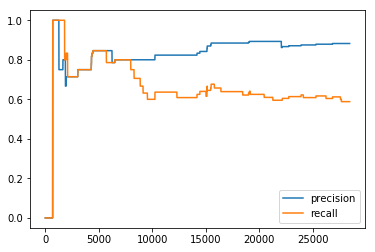

In [35]:
df.plot(use_index=True, y=['precision','recall'])

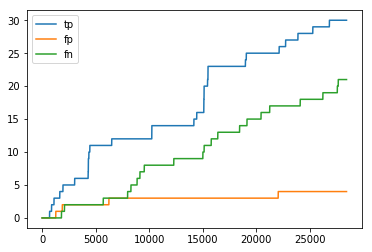

In [36]:
df.plot(use_index=True,y=['tp','fp','fn'])

As expected the number of true negative (the legit transaction) is increasing steadily given that they are the vast majority of the transactions. For this reason it is better not to consider accuracy as a performance metric as it would be very close to 100%.

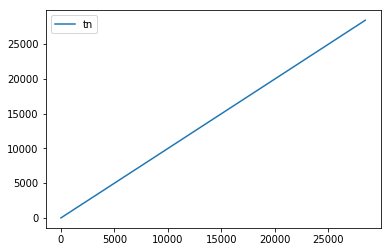

In [32]:
df.plot(use_index=True, y=['tn'])

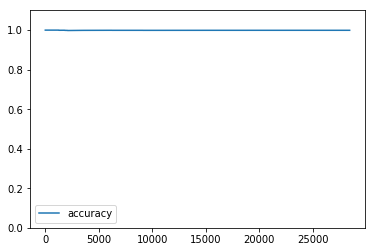

In [49]:
df['accuracy']=((df.tp + df.tn)/(df.tp+df.fp+df.tn+df.fn))
df.plot(use_index=True, y=['accuracy'],ylim=(0,1.1))

In [50]:
df.tail(1)

,precision,recall,tp,fn,fp,tn,accuracy
28452,0.882353,0.588235,30,21,4,28398,0.999121


In fact, a baseline model always guessing that a transaction is legit will achieve a 99.89 accuracy, but a precision and recall of 0 as no true positive will be identified


In [53]:
((df.tn + df.fn)/(df.tp+df.fp+df.tn+df.fn)).tail(1)

28452    0.998805
dtype: float64

# Balanced training

In [77]:
df_bal = pd.read_csv("../data/results_subsample.csv",)

In [78]:
df_bal.head()

,precision,recall,tp,fn,fp,tn
0,0.0,0.0,0,0,0,1
1,0.0,0.0,0,0,0,2
2,0.0,0.0,0,0,0,3
3,0.0,0.0,0,0,0,4
4,0.0,0.0,0,0,0,5


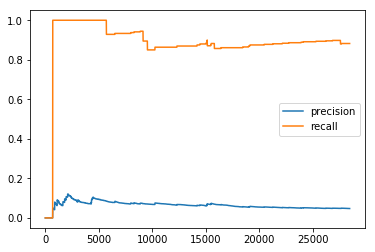

In [79]:
df_bal.plot(use_index=True, y=['precision','recall'])

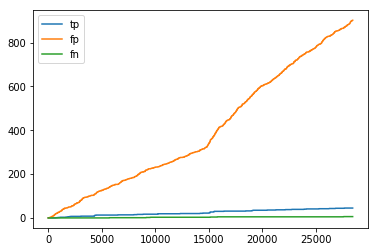

In [84]:
df_bal.plot(use_index=True,y=['tp','fp','fn'])